### Problem Statement: Finding the non popular item sets in the Online Retail dataset and providing the suggestions as grouped products in the website when customers add products to the cart.

Importing necessary libraries and setting the max display columns for the pandas dataframe

In [26]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

Read the data from the excel file and load it into dataframes

In [27]:
def read_all_sheets_from_excel(path: str) -> dict:
    xls = pd.ExcelFile(path)
    df_dict = {sheet_name: xls.parse(sheet_name) for sheet_name in xls.sheet_names}
    return df_dict

# Load the dataset
file_path = 'online_retail_II.xlsx'
dataframes = read_all_sheets_from_excel(file_path)

# Print each dataframe name
print("Dataframes in this file:", ", ".join(dataframes.keys()))

Dataframes in this file: Year 2009-2010, Year 2010-2011


Find the summary of the loaded datasets

In [28]:
# Load the first sheet to examine its structure
data = dataframes['Year 2009-2010']
# data = dataframes['Year 2010-2011']

# Display the first few rows and summary statistics
display(data.head())
print("Summary Statistics:")
data.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Summary Statistics:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
count,525461.0,525461,522533,525461.000000,525461,525461.000000,417534.000000,525461
unique,28816.0,4632,4681,NaN,NaN,NaN,NaN,40
top,537434.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,675.0,3516,3549,NaN,NaN,NaN,NaN,485852
mean,NaN,NaN,NaN,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478,NaN
min,NaN,NaN,NaN,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2010-03-21 12:20:00,1.250000,13983.000000,NaN
50%,NaN,NaN,NaN,3.000000,2010-07-06 09:51:00,2.100000,15311.000000,NaN
75%,NaN,NaN,NaN,10.000000,2010-10-15 12:45:00,4.210000,16799.000000,NaN
max,NaN,NaN,NaN,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000,NaN


In [29]:
data.shape

(525461, 8)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


Cleaning the data and converting the dataframe to lists as the apriori function accepts the input as list

In [31]:
# Filter out negative or zero quantities and missing descriptions
cleaned_df = data[(data['Quantity'] > 0) & (data['Description'].notnull())]

# Group by Invoice and list all items
transactions = cleaned_df.groupby('Invoice')['Description'].apply(list)

# Convert all items in transactions to strings to avoid the TypeError
cleaned_transactions = transactions.apply(lambda x: [str(i) for i in x])

TransactionEncoder is used to convert transaction data into a format suitable for association rule mining algorithms. Each row of the resulting array represents a transaction, and each column represents an item in the dataset. If an item is present in a transaction, the corresponding value in the array is set to True; otherwise, it is set to False.

In [32]:
# Apply the Transaction Encoder with the cleaned transactions
encoder = TransactionEncoder()
transactions_encoded = encoder.fit(cleaned_transactions).transform(cleaned_transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

Apply apriori algorithm and association rules

In [35]:
# Applying Apriori with the cleaned data
frequent_itemsets = apriori(transactions_df, min_support=0.02, use_colnames=True)

# Generating Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Displaying the top 10 association rules based on confidence
rules.sort_values('confidence', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
37,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.047660,0.078084,0.037899,0.795205,10.183955,0.034178,4.501648
32,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.050755,0.157882,0.036709,0.723265,4.581039,0.028696,3.043043
47,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.045089,0.054278,0.028805,0.638860,11.770147,0.026358,2.618710
40,(VINTAGE HEADS AND TAILS CARD GAME ),(VINTAGE SNAP CARDS),0.035519,0.047660,0.021140,0.595174,12.487957,0.019447,2.352469
1,(72 SWEETHEART FAIRY CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.041470,0.063610,0.022473,0.541906,8.519198,0.019835,2.044100
15,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.051945,0.063372,0.027853,0.536205,8.461247,0.024561,2.019489
10,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.048993,0.052183,0.026234,0.535471,10.261409,0.023678,2.040384
27,(LUNCH BAG PINK RETROSPOT),(LUNCH BAG RED SPOTTY),0.038661,0.057992,0.020521,0.530788,9.152828,0.018279,2.007640
46,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.054278,0.045089,0.028805,0.530702,11.770147,0.026358,2.034764
9,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE TEA AND SYMPATHY),0.044184,0.048374,0.022806,0.516164,10.670264,0.020669,1.966835


Finding the non popular frequent item sets which are not often sold together

In [40]:
top_10_non_popular_items = rules.sort_values('confidence').head(10)
print(top_10_non_popular_items)


                             antecedents                           consequents  antecedent support  consequent support   support  confidence      lift  leverage  conviction
35  (WHITE HANGING HEART T-LIGHT HOLDER)            (REGENCY CAKESTAND 3 TIER)            0.157882            0.096177  0.020426    0.129373  1.345156  0.005241    1.038129
13  (WHITE HANGING HEART T-LIGHT HOLDER)               (HEART OF WICKER LARGE)            0.157882            0.052183  0.020664    0.130881  2.508107  0.012425    1.090549
7   (WHITE HANGING HEART T-LIGHT HOLDER)       (ASSORTED COLOUR BIRD ORNAMENT)            0.157882            0.067276  0.020997    0.132992  1.976802  0.010375    1.075796
44  (WHITE HANGING HEART T-LIGHT HOLDER)   (WOODEN PICTURE FRAME WHITE FINISH)            0.157882            0.045089  0.021759    0.137817  3.056561  0.014640    1.107550
20  (WHITE HANGING HEART T-LIGHT HOLDER)            (LOVE BUILDING BLOCK WORD)            0.157882            0.051945  0.021902    0.1

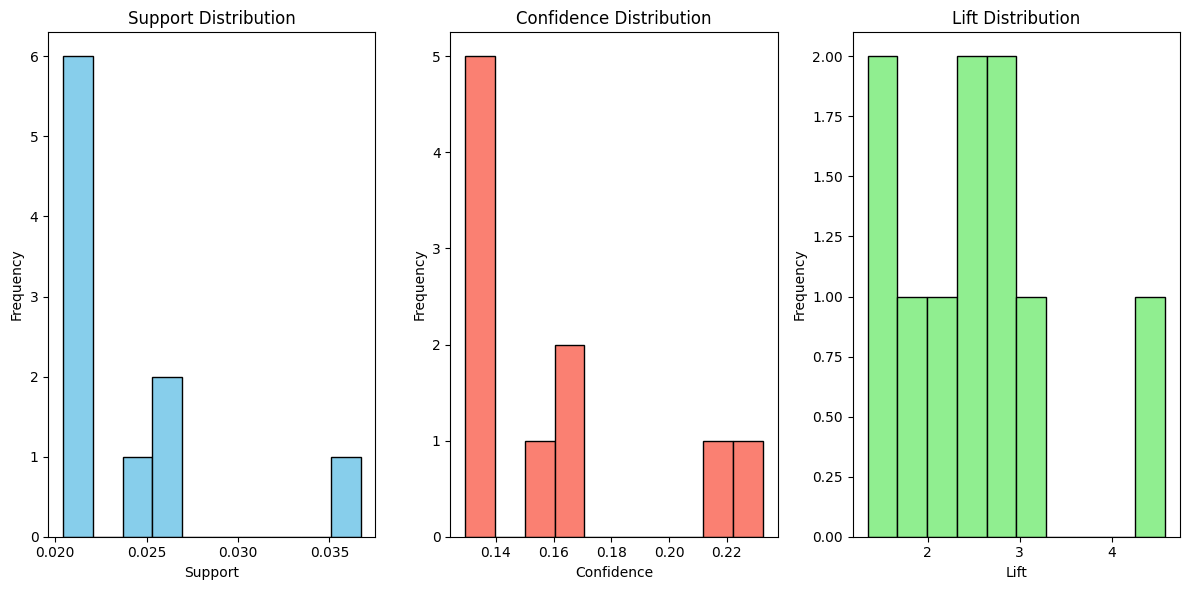

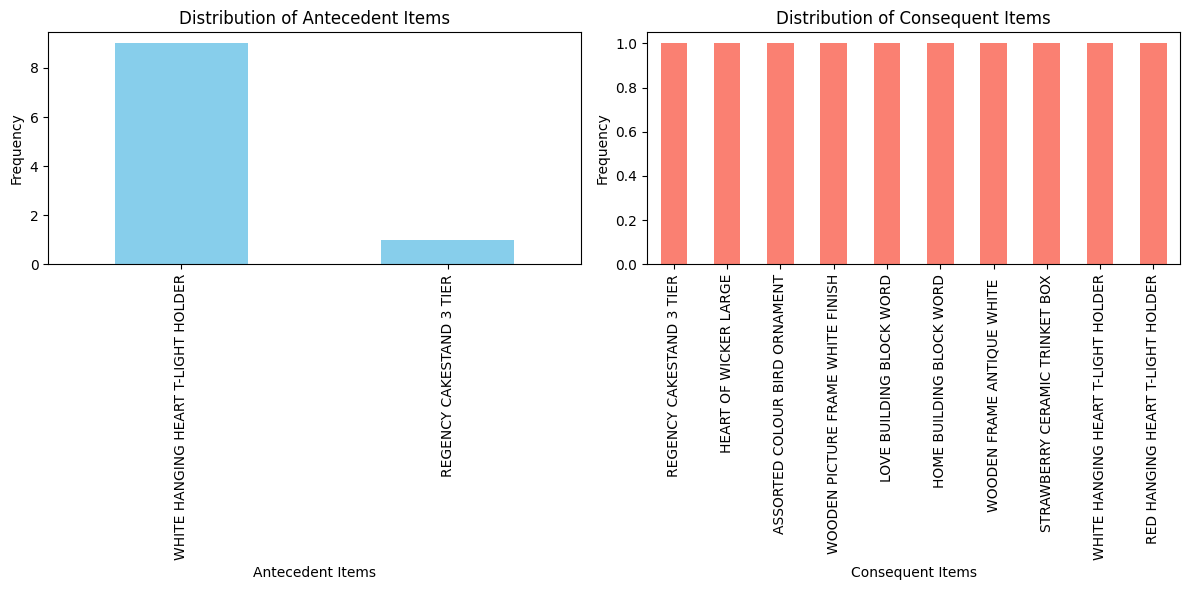

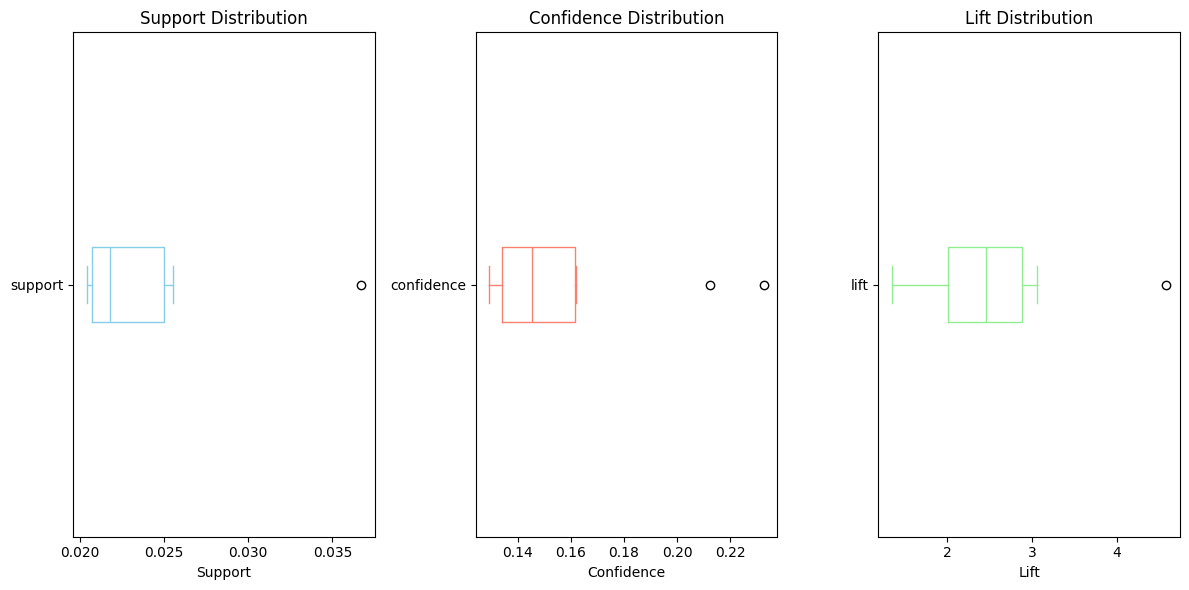

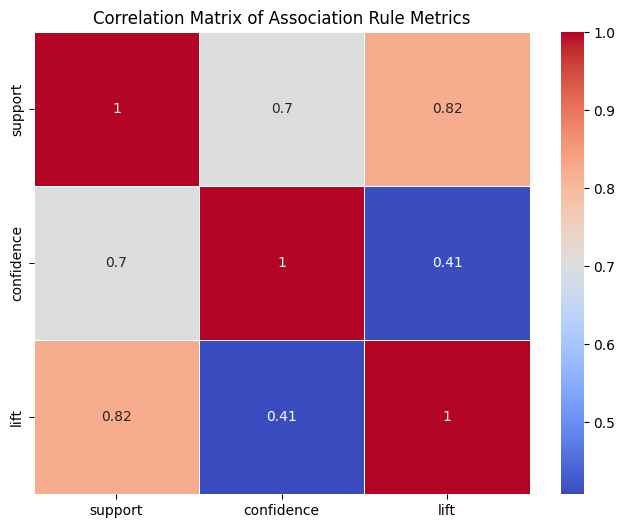

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Support, Confidence, and Lift
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(top_10_non_popular_items['support'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.title('Support Distribution')

plt.subplot(1, 3, 2)
plt.hist(top_10_non_popular_items['confidence'], bins=10, color='salmon', edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Confidence Distribution')

plt.subplot(1, 3, 3)
plt.hist(top_10_non_popular_items['lift'], bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.title('Lift Distribution')

plt.tight_layout()
plt.show()

# Distribution of Antecedent and Consequent Items
antecedent_items = top_10_non_popular_items['antecedents'].explode().value_counts()
consequent_items = top_10_non_popular_items['consequents'].explode().value_counts()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
antecedent_items.plot(kind='bar', color='skyblue')
plt.xlabel('Antecedent Items')
plt.ylabel('Frequency')
plt.title('Distribution of Antecedent Items')

plt.subplot(1, 2, 2)
consequent_items.plot(kind='bar', color='salmon')
plt.xlabel('Consequent Items')
plt.ylabel('Frequency')
plt.title('Distribution of Consequent Items')

plt.tight_layout()
plt.show()

# Association Rule Metrics Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
top_10_non_popular_items['support'].plot(kind='box', vert=False, color='skyblue')
plt.xlabel('Support')
plt.title('Support Distribution')

plt.subplot(1, 3, 2)
top_10_non_popular_items['confidence'].plot(kind='box', vert=False, color='salmon')
plt.xlabel('Confidence')
plt.title('Confidence Distribution')

plt.subplot(1, 3, 3)
top_10_non_popular_items['lift'].plot(kind='box', vert=False, color='lightgreen')
plt.xlabel('Lift')
plt.title('Lift Distribution')

plt.tight_layout()
plt.show()

# Correlation Analysis
plt.figure(figsize=(8, 6))
correlation_matrix = top_10_non_popular_items[['support', 'confidence', 'lift']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Association Rule Metrics')
plt.show()
